In [1]:
import polars as pl
import pandas as pd

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_fmt_float("full")

polars.config.Config

In [2]:
# load weekly perp_margin_vol
weekly_perp_vol = pl.read_csv("data/weekly_perp_vol.csv")

In [3]:
# convert timestamp to datetime
weekly_perp_vol = weekly_perp_vol.with_columns(
    pl.col("timestamp").str.to_date(format='%Y-%m-%d')
)

In [4]:
# filter data for dates between 3/1/23 and 5/31/23
weekly_perp_vol = weekly_perp_vol.filter(
    (pl.col("timestamp") >= pl.date(2023,3,1)) & (pl.col("timestamp") <= pl.date(2023,5,31))
)

### Plot Weekly Perp Dex Volume

In [7]:
pivot_weekly_perp_vol = weekly_perp_vol.pivot(
    index="timestamp",
    columns="protocol",
    values="weekly_vol",
    # aggregate_function=pl.col('price').mean()
)

/tmp/ipykernel_50714/2301684709.py:1: DeprecationWarning: In a future version of polars, the default `aggregate_function` will change from `'first'` to `None`. Please pass `'first'` to keep the current behaviour, or `None` to accept the new one.
  pivot_weekly_perp_vol = weekly_perp_vol.pivot(


In [10]:
pd_chart = pivot_weekly_perp_vol.to_pandas()

In [11]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import thanefield_charting as tc

# Format the y-axis tick labels
def format_y_ticks(value, pos):
    if value >= 1e9:
        return f'${value / 1e9:.1f}B'
    elif value >= 1e6:
        return f'${value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'${value / 1e3:.1f}K'
    else:
        return f'${value:.0f}'

In [22]:
# set timestamp as index
pd_chart = pd_chart.set_index('timestamp')

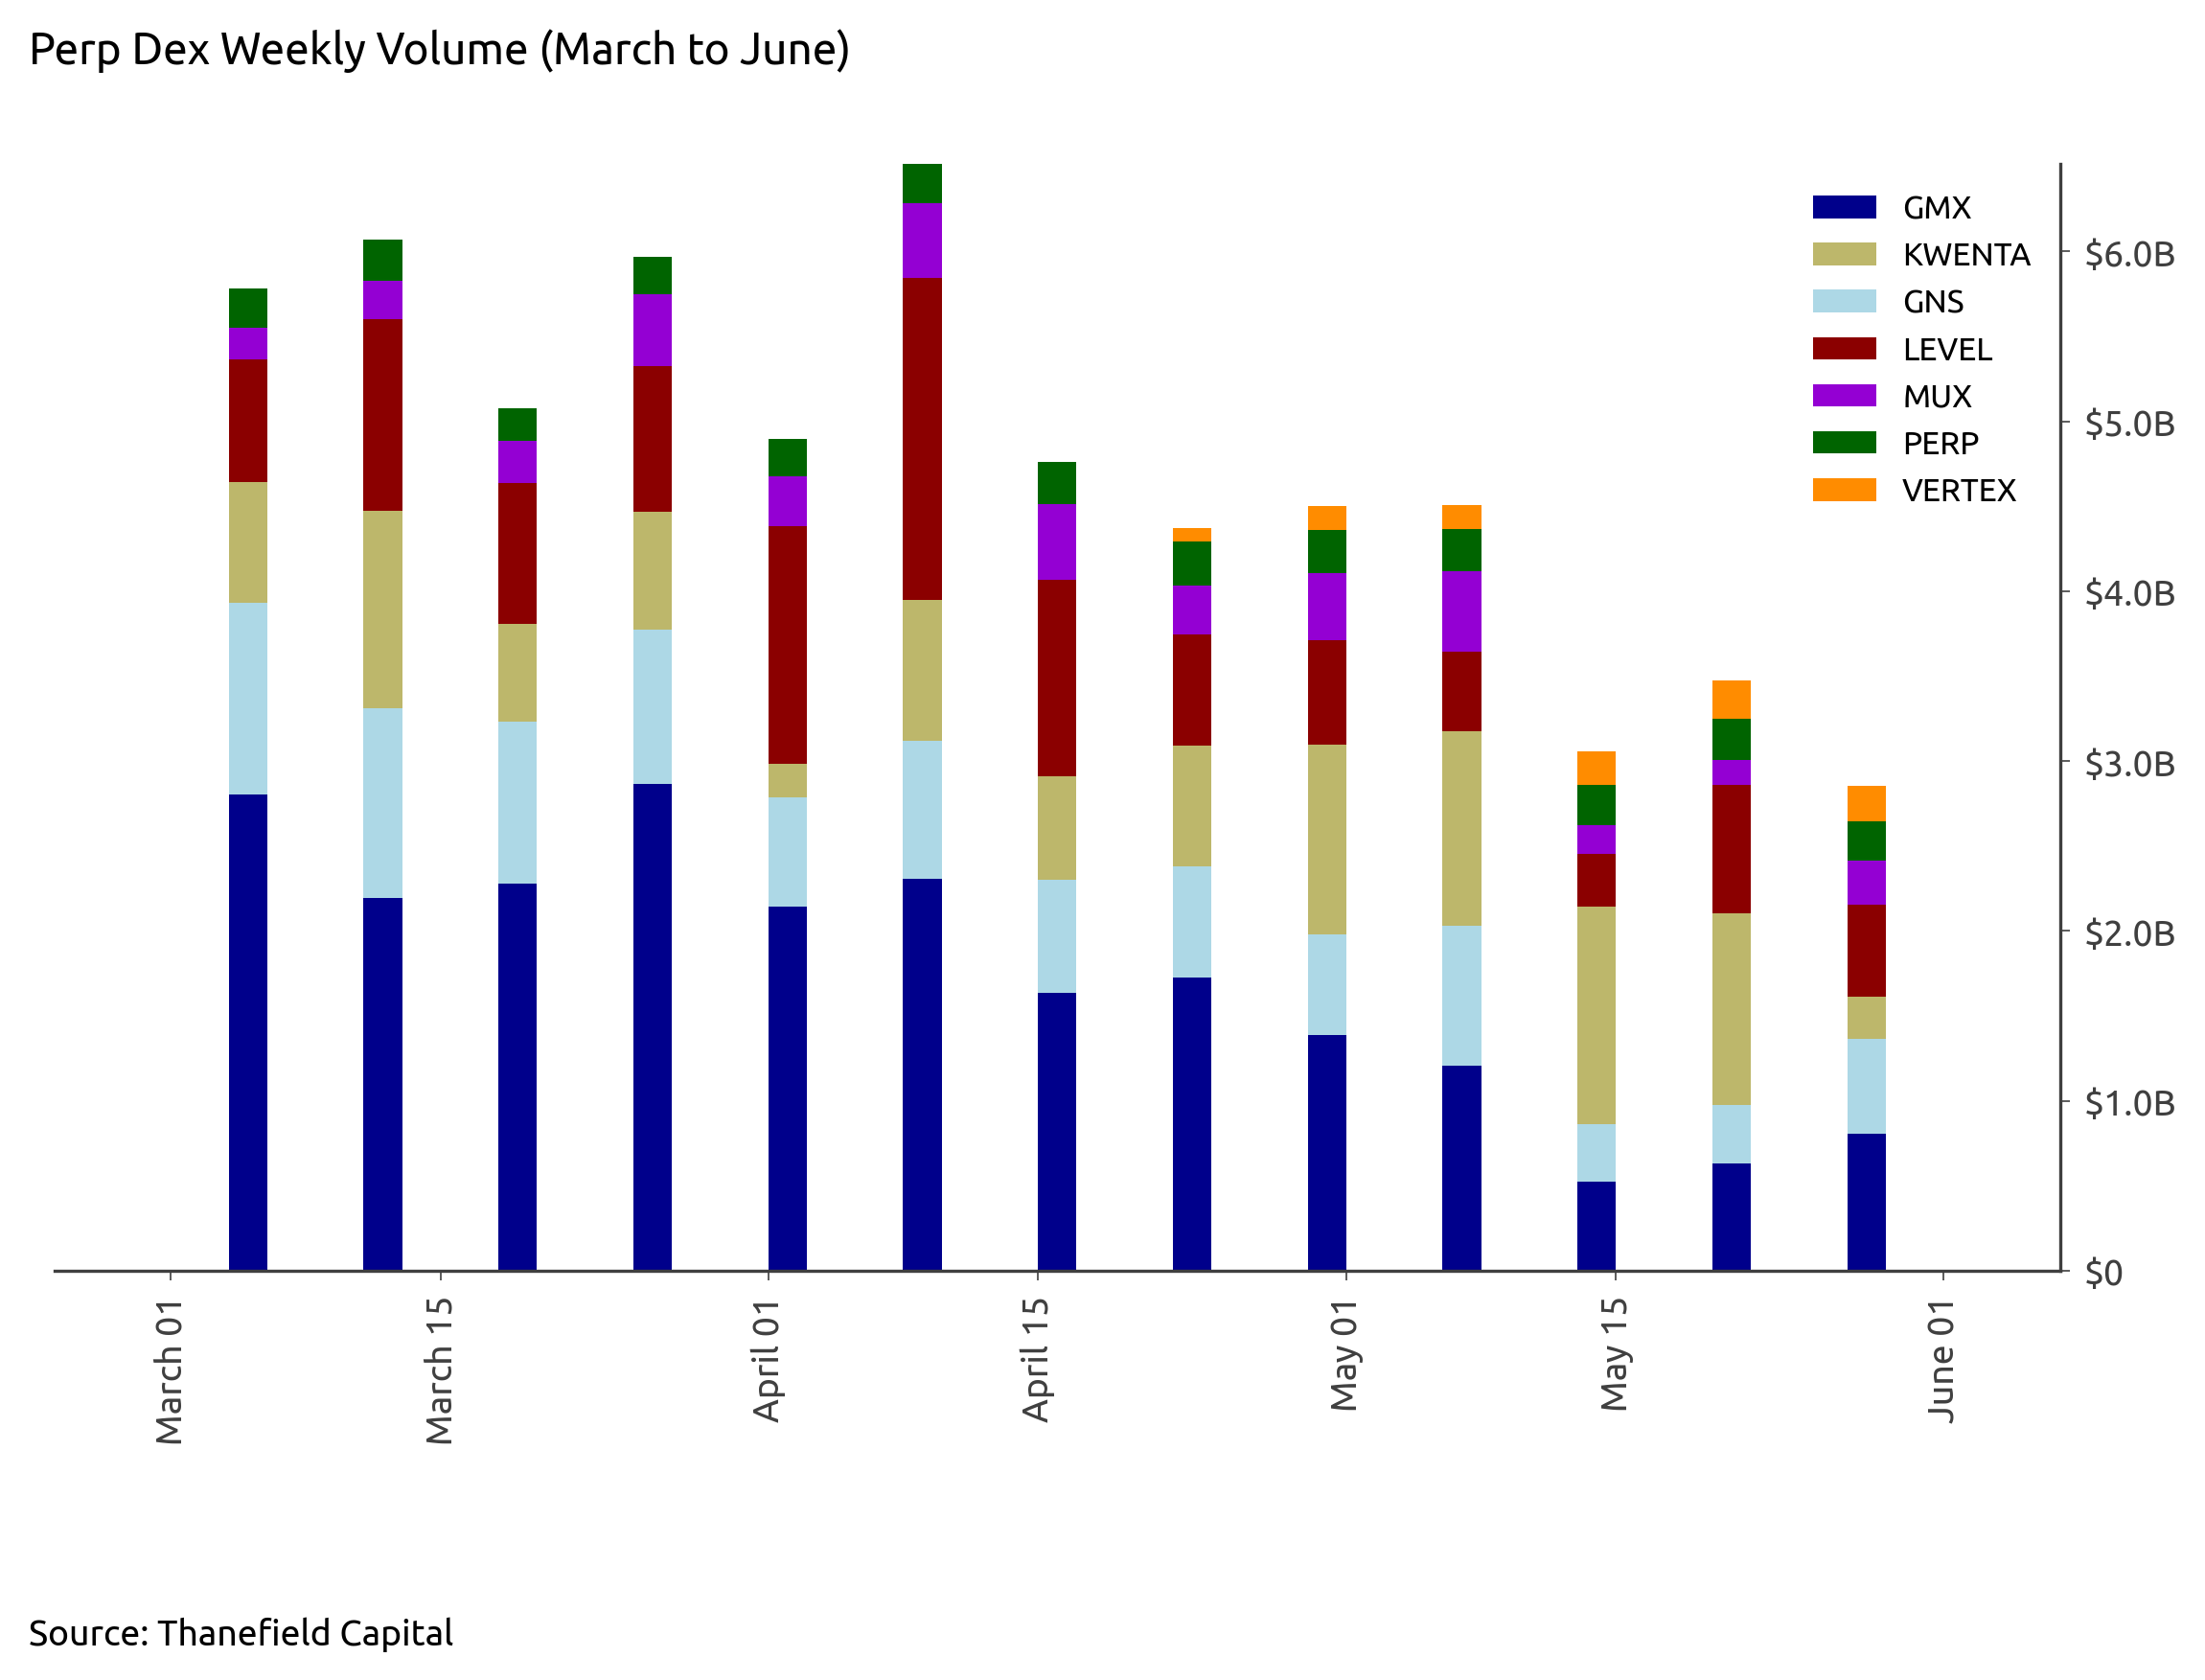

In [29]:
# Create the bar chart
fig, ax = tc.chart('Perp Dex Weekly Volume (March to June)', dates=False)

# Stacked bar chart
ax.bar(pd_chart.index, pd_chart['GMX'], color='darkblue', label='GMX', align='edge', width=-2)
ax.bar(pd_chart.index, pd_chart['KWENTA'], bottom=pd_chart['GMX']+pd_chart['GNS'], color='darkkhaki', label='KWENTA', align='edge', width=-2)
ax.bar(pd_chart.index, pd_chart['GNS'], bottom=pd_chart['GMX'], color='lightblue', label='GNS', align='edge', width=-2)
ax.bar(pd_chart.index, pd_chart['LEVEL'], bottom=pd_chart['GMX']+pd_chart['GNS']+pd_chart['KWENTA'], color='darkred', label='LEVEL', align='edge', width=-2)
ax.bar(pd_chart.index, pd_chart['MUX'], bottom=pd_chart['GMX']+pd_chart['GNS']+pd_chart['KWENTA']+pd_chart['LEVEL'], color='darkviolet', label='MUX', align='edge', width=-2)
ax.bar(pd_chart.index, pd_chart['PERP'], bottom=pd_chart['GMX']+pd_chart['GNS']+pd_chart['KWENTA']+pd_chart['LEVEL']+pd_chart['MUX'], color='darkgreen', label='PERP', align='edge', width=-2)
ax.bar(pd_chart.index, pd_chart['VERTEX'], bottom=pd_chart['GMX']+pd_chart['GNS']+pd_chart['KWENTA']+pd_chart['LEVEL']+pd_chart['MUX']+pd_chart['PERP'], color='darkorange', label='VERTEX', align='edge', width=-2)

# Apply the custom formatting function to the y-axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_y_ticks))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%B %d'))


# formatting
tc.legend(ax)
tc.set_xmargin(ax, margin=.05)
# plt.tight_layout()
plt.xticks(rotation=90)

# save chart
tc.save('charts/perp_dex_weekly_vol.png')